The Ulitmate Data Challenge

#Performed by Carolyn MASSA on April 20, 2020


In [1]:



#Basic Libraries for data collection and processing

import json
import datetime
import pandas as pd
import numpy as np

#common tools for data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('ggplot')
%matplotlib inline

#Common Libraries for Models

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



Part 1 - Exploratory Data Analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:

logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:

logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
# Turn the datetimes into the index and create a count which is them summed during resampling
logins = logins.set_index('login_time')
logins['count'] = 1
logins = logins.resample('15T').sum()
logins.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
logins.tail()

,count
login_time,
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2
1970-04-13 18:30:00,7
1970-04-13 18:45:00,6


C:\Users\1800r\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


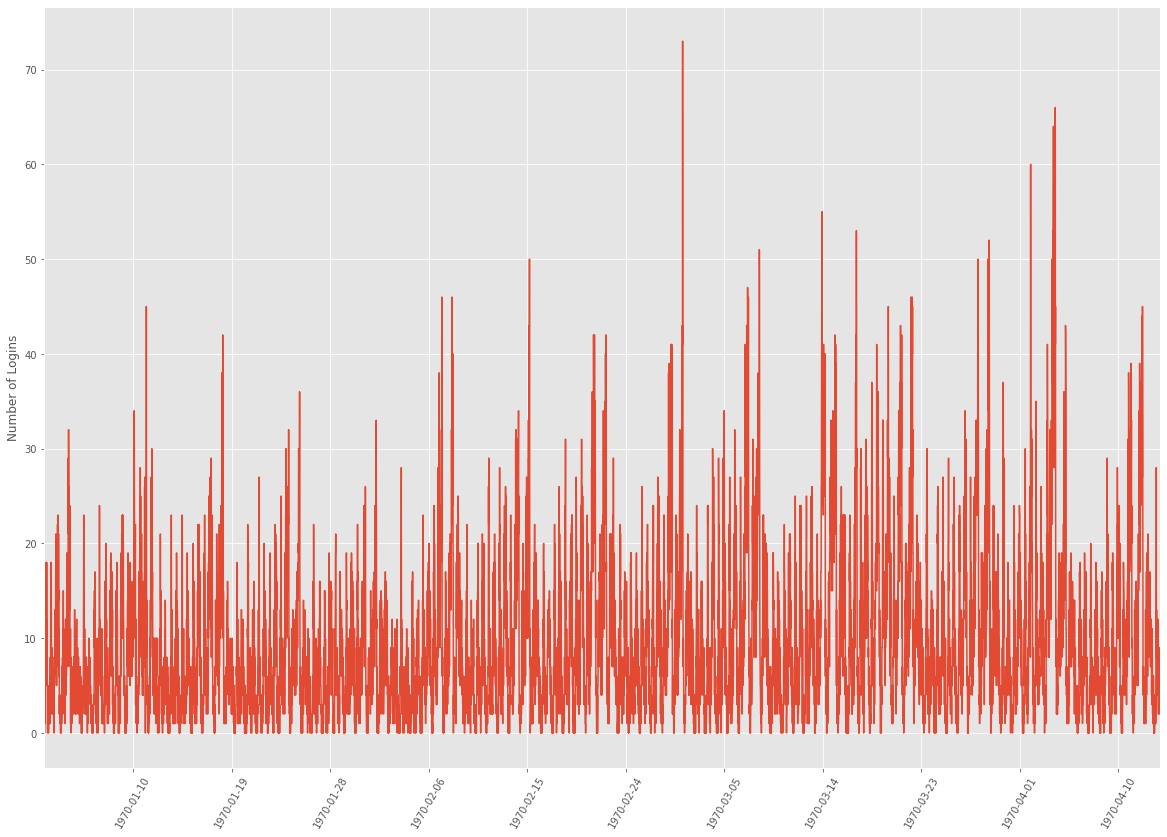

In [8]:

tick_spacing = 9

fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(111)
ax.plot(logins)
plt.xticks(rotation=60)
plt.ylabel('Number of Logins')
plt.xlim([logins.index[0], logins.index[-1]])
ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

The lines here are a bit too close together though we can notice a pattern that each month has a peak.  We now need to shorten the timescale by breaking it down to Months, weeks, and days.

In [9]:

# Reset the index to use datetime objects
logins = logins.reset_index()

In [10]:

# Applying a day of the week column (0=Monday, 6=Sunday)
logins['weekday'] = logins.login_time.apply(lambda x: x.weekday())

In [11]:
# Applying month column (1 for Jan, etc.)
logins['month'] = logins.login_time.apply(lambda x: x.month)

In [12]:
# Setting index to datetime
logins = logins.set_index('login_time')

In [13]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Data columns (total 3 columns):
count      9788 non-null int64
weekday    9788 non-null int64
month      9788 non-null int64
dtypes: int64(3)
memory usage: 305.9 KB


In [14]:
# Creating a dictionary to use with the .replace() function
cleanup_dict = {'weekday': {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                            4: 'Friday', 5:'Saturday', 6: 'Sunday'},
                'month': {1: 'January', 2: 'February', 3: 'March', 4: 'April'}}

In [15]:

# Replacing the ints with the real names
logins.replace(cleanup_dict, inplace=True)

In [16]:


# Turning the variables into categorical
logins.weekday = logins.weekday.astype('category')

In [17]:

logins.month = logins.month.astype('category')

In [18]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Data columns (total 3 columns):
count      9788 non-null int64
weekday    9788 non-null category
month      9788 non-null category
dtypes: category(2), int64(1)
memory usage: 172.6 KB


In [19]:

logins.head()

,count,weekday,month
login_time,,,
1970-01-01 20:00:00,2,Thursday,January
1970-01-01 20:15:00,6,Thursday,January
1970-01-01 20:30:00,9,Thursday,January
1970-01-01 20:45:00,7,Thursday,January
1970-01-01 21:00:00,1,Thursday,January


In [20]:
# Subsetting the data by month to further analyze log ins
jan_df = logins.drop('weekday', axis=1).loc[logins.month=='January'].drop('month', axis=1)
feb_df = logins.drop('weekday', axis=1).loc[logins.month=='February'].drop('month', axis=1)
mar_df = logins.drop('weekday', axis=1).loc[logins.month=='March'].drop('month', axis=1)
apr_df = logins.drop('weekday', axis=1).loc[logins.month=='April'].drop('month', axis=1)

# Subsetting March to look at a single month
mar_1 = mar_df['03-01-1970' : '03-07-1970']
mar_2 = mar_df['03-08-1970' : '03-14-1970']
mar_3 = mar_df['03-15-1970' : '03-21-1970']
mar_4 = mar_df['03-22-1970' : '03-29-1970']

# Subsetting a week in March to look at a single week
sun = mar_2['03-08-1970']
mon = mar_2['03-09-1970']
tue = mar_2['03-10-1970']
wed = mar_2['03-11-1970']
thu = mar_2['03-12-1970']
fri = mar_2['03-13-1970']
sat = mar_2['03-14-1970']

months = [jan_df, feb_df, mar_df, apr_df]
mar_weeks = [mar_1, mar_2, mar_3, mar_4]
days = [sun, mon, tue, wed, thu, fri, sat, sun]

In [21]:
jan_df.head(5)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


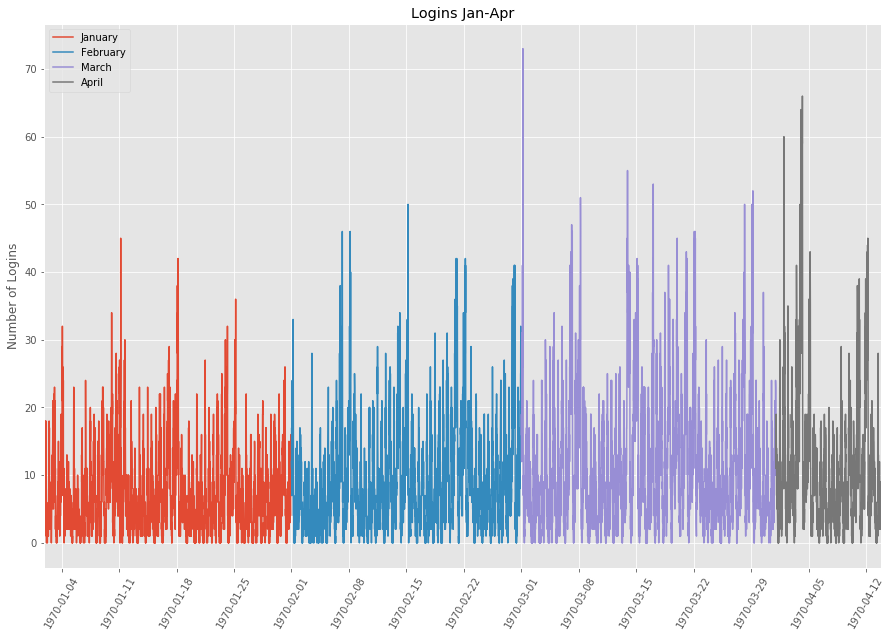

In [22]:
# Plotting the monthly trends for insights
tick_spacing = 7
month_labels=['January', 'February', 'March', 'April']

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for df in months:
    ax.plot(df)
plt.xticks(rotation=60)
plt.ylabel('Number of Logins')
plt.legend(month_labels, loc='upper left')
plt.title('Logins Jan-Apr')
plt.xlim([logins.index[0], logins.index[-1]])
ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

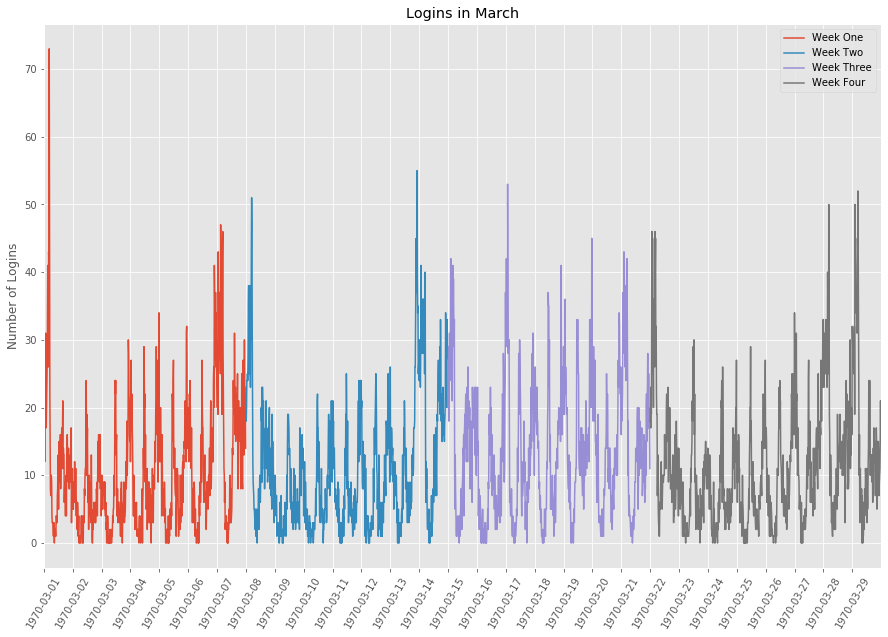

In [23]:
tick_spacing = 1
week_labels=['Week One', 'Week Two', 'Week Three', 'Week Four']

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for df in mar_weeks:
    ax.plot(df)
plt.xticks(rotation=60)
plt.ylabel('Number of Logins')
plt.title('Logins in March')
plt.legend(week_labels, loc='upper right')
plt.xlim([mar_1.index[0], mar_4.index[-1]])
ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

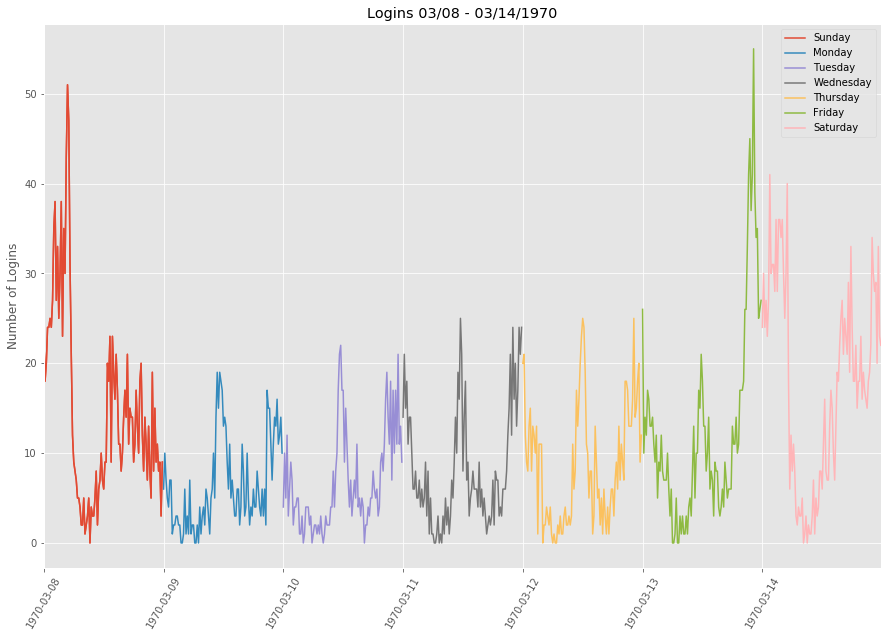

In [24]:
tick_spacing = 1
day_labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for df in days:
    ax.plot(df)
plt.xticks(rotation=60)
plt.ylabel('Number of Logins')
plt.title('Logins 03/08 - 03/14/1970')
plt.legend(day_labels, loc='upper right')
plt.xlim([mar_2.index[0], mar_2.index[-1]])
ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

Insights so far:

We can see a trend that when the months advance from the December/January Months into Febuary and March.

We can review a month and we can see the trend which fluctuates by day of the week and by hour. The number of logins increases as the weekend approaches and reach their peak when the weekend is over. There are distinct peaks in total logins each day at major time frames during the day as in the morning, lumch and dinner.

# Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?


Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: a. how you will implement the experiment b. what statistical test(s) you will conduct to verify the significance of the observation c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.



Answer:

1. With the key measure of success being drivers serving both cities, the metric by which to measure it would be the most the largest amount time the drivers spend in each city calculated as a percentage. Given there is a toll between the cities we assume Gotham drivers spend the majority of their time in Gotham and Metropolis drivers in Metropolis which is closer to them. So, identifying a significant change in the percentage of time in each city would be the best metric when the company decided to reimburse the drivers for the toll fee.

2. I would approach this problem like this:

   I assume that all location data and times of each driver have been collected.

   Account for all toll reimbursements in any severe weather conditions such as snow and other severe weather that can cause delays for drivers when driving long distances.
   
Collect and separate the data into Gotham drivers and Metropolis drivers and perform one-tailed Z-tests. The Z-test is applicable as the sample size could easily be sufficient for the central limit theorem to apply (n > 30), and it can be one-tailed as we have a reasonable assumption that the alternate hypothesis will shift one direction. We will assume that those drivers tend to stay in one of the two cities due to the toll fees and they may live closer to each location. but we may be incorrect in this assumption.

The hypotheses are as follows:

$H_{0}$: There is no difference in mean percentage of time spent in Metropolis or Gotham.
$H_{A}$: There is a difference in mean percentage of time spent in Metropolis or Gotham

As stated previously, the key metric for success would be a significant difference in percentage of time in each city, but there are other factors that would need to be taken into account.  One one hand the drivers may be willing to drive more with toll reimbursements and increase revenue for the city but this may not happen. More drivers may want to join as they would have access to more areas to make money thus also increasing the revenue for the company.  The company may want to strike a reduced fare deal with each city as they may be able to prove that their service is a viable solution for clients.  I do recall more UBER drivers signing up when Uber, for instance, opened more opportunites to advance and cover more territory after drivers met their basic requirements. THis all depends on the typical schedules of the current drivers and how many miles they drive each day.


Part 3 - Predictive Modeling

CHALLENGE DETAILS

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). 

What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? 

Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


Data description
city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday


In [25]:
file = open('ultimate_data_challenge.json', 'r')
riders = pd.DataFrame(json.load(file))
file.close()

riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [26]:
riders.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [27]:
riders.info() # Let's review the data, check for outliers and null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


I notice some empty values in both the both the ratings column and the phone column so I check their averages with intention to imput them based on values

In [28]:
#I need to transform my dates for easier processing

riders.last_trip_date = pd.to_datetime(riders.last_trip_date)
riders.signup_date = pd.to_datetime(riders.signup_date)


In [29]:
riders.avg_rating_of_driver.mean() 

                       

4.6015592912744685

In [30]:
riders.avg_rating_by_driver.mean() 

4.778158195947439

In [31]:
riders.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

#Below I impute the missing values 1) ratings will be by average and sine there are more iphones I will replace missing phone types with iPhones

In [32]:
riders.avg_rating_of_driver.fillna(riders.avg_rating_of_driver.mean(), inplace=True)
riders.avg_rating_by_driver.fillna(riders.avg_rating_by_driver.mean(), inplace=True)
riders.phone.fillna('iPhone', inplace=True)

In [33]:

riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [34]:
#We will be highly concerned with distances that the drivers drive per trip

riders.avg_dist.mean()

5.796826599999984

Text(0.5, 1.0, 'Histogram of average distance per trip')

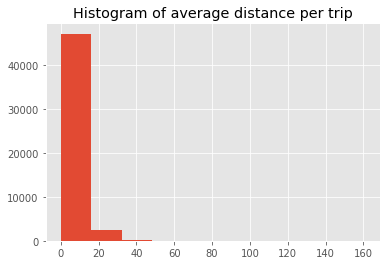

In [35]:
plt.hist(riders.avg_dist) #Let's see it on a histogram
plt.title('Histogram of average distance per trip')

Text(0.5, 1.0, 'Boxplot of avg_dist')

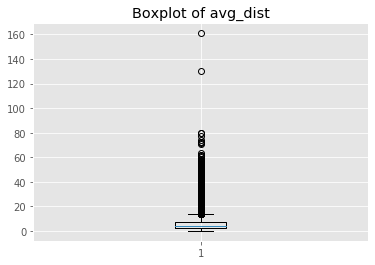

In [36]:
plt.boxplot(riders.avg_dist) # in the box plot we see outliers far from the mean which need to be delt with
plt.title('Boxplot of avg_dist')

In [37]:
riders.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [38]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed.

Text(0.5, 1.0, 'Boxplot of avg_rating_by_driver')

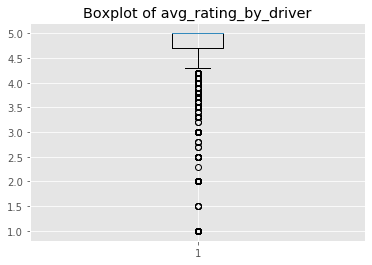

In [39]:
plt.boxplot(riders.avg_rating_by_driver)
plt.title('Boxplot of avg_rating_by_driver')


Text(0.5, 1.0, 'Boxplot of surge_pct')

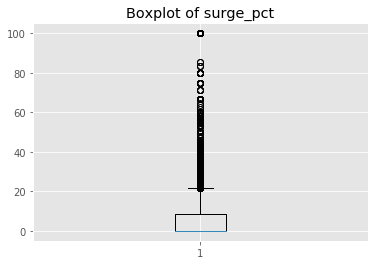

In [40]:
plt.boxplot(riders.surge_pct)
plt.title('Boxplot of surge_pct')

In [41]:
riders.groupby('city').surge_pct.sum()

#Winterfell has the highest surge rates by count but AStapor has the highest by average


city
Astapor           167659.8
King's Landing    100965.5
Winterfell        173851.5
Name: surge_pct, dtype: float64

In [42]:
riders.groupby('city').surge_pct.mean()

city
Astapor           10.140305
King's Landing     9.966979
Winterfell         7.449927
Name: surge_pct, dtype: float64

Text(0.5, 1.0, 'Boxplot of trips_in_first_30_days')

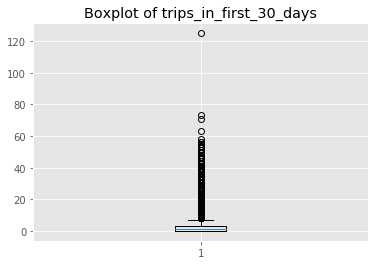

In [43]:

# trips_in_the_first_30_days
plt.boxplot(riders.trips_in_first_30_days)
plt.title('Boxplot of trips_in_first_30_days')

Text(0.5, 1.0, 'Boxplot of avg_rating_by_driver')

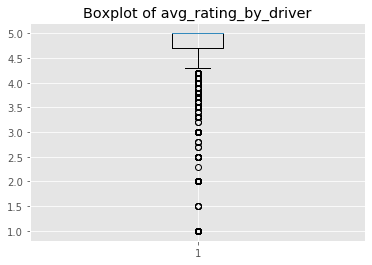

In [44]:
# as per the data review above for details we notice many outliers for the ratings of drivers
# avg_rating_by_driver
plt.boxplot(riders.avg_rating_by_driver)
plt.title('Boxplot of avg_rating_by_driver')

Text(0.5, 1.0, 'Boxplot of weekday_pct')

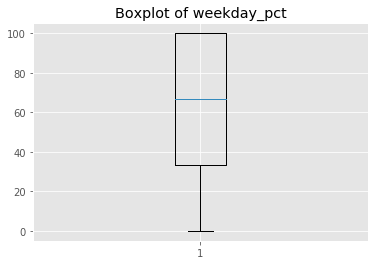

In [45]:
# weekday_pct ; I do not notice outliers in this box plot
plt.boxplot(riders.weekday_pct)
plt.title('Boxplot of weekday_pct')

Text(0.5, 1.0, 'Boxplot of trips_in_first_30_days')

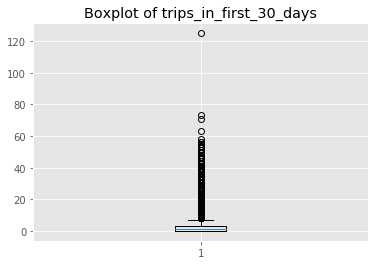

In [46]:

# trips_in_the_first_30_days
plt.boxplot(riders.trips_in_first_30_days)
plt.title('Boxplot of trips_in_first_30_days')

Since there are outliers in most of my box plots I must remove them from my dataset. Since an "outlier" is classified as 3 SD from the mean I will use this definition.

In [47]:
#Here we calcualate the SD by subtracting the average from the total then determine if the result is less or equal to 3 x the SD then drop
riders = riders[np.abs(riders.avg_rating_by_driver-riders.avg_rating_by_driver.mean())<=(3*riders.avg_rating_by_driver.std())]

riders = riders[np.abs(riders.avg_dist-riders.avg_dist.mean())<=(3*riders.avg_dist.std())]

riders = riders[np.abs(riders.avg_rating_of_driver-riders.avg_rating_of_driver.mean())<=(3*riders.avg_rating_of_driver.std())]

riders = riders[np.abs(riders.avg_surge-riders.avg_surge.mean())<=(3*riders.avg_surge.std())]

riders = riders[np.abs(riders.surge_pct-riders.surge_pct.mean())<=(3*riders.surge_pct.std())]

riders = riders[np.abs(riders.trips_in_first_30_days-riders.trips_in_first_30_days.mean())<=(3*riders.trips_in_first_30_days.std())]

riders = riders.reset_index(drop=True)

In [48]:
riders.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,44663.000000,44663.000000,44663.000000,44663.00000,44663.000000,44663.000000,44663.000000
mean,2.008620,4.641081,1.043404,5.73348,61.457994,5.376017,4.822471
std,2.532568,0.453559,0.098878,11.57870,36.346570,4.319605,0.287653
min,0.000000,3.000000,1.000000,0.00000,0.000000,0.000000,3.500000
25%,0.000000,4.500000,1.000000,0.00000,33.300000,2.440000,4.700000
50%,1.000000,4.800000,1.000000,0.00000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.030000,6.30000,100.000000,6.770000,5.000000
max,14.000000,5.000000,1.710000,54.50000,100.000000,22.870000,5.000000


I notice nearly 5337 observations have been dropped

In [49]:
44666/50000 #we now have nearly 90% of our data to review

0.89332

In [50]:
#Let's now check when the drivers have signed up since their longevity is typically short
riders.signup_date.unique() 

array(['2014-01-25T00:00:00.000000000', '2014-01-29T00:00:00.000000000',
       '2014-01-06T00:00:00.000000000', '2014-01-10T00:00:00.000000000',
       '2014-01-27T00:00:00.000000000', '2014-01-09T00:00:00.000000000',
       '2014-01-24T00:00:00.000000000', '2014-01-28T00:00:00.000000000',
       '2014-01-21T00:00:00.000000000', '2014-01-03T00:00:00.000000000',
       '2014-01-13T00:00:00.000000000', '2014-01-15T00:00:00.000000000',
       '2014-01-12T00:00:00.000000000', '2014-01-02T00:00:00.000000000',
       '2014-01-19T00:00:00.000000000', '2014-01-16T00:00:00.000000000',
       '2014-01-26T00:00:00.000000000', '2014-01-17T00:00:00.000000000',
       '2014-01-31T00:00:00.000000000', '2014-01-22T00:00:00.000000000',
       '2014-01-20T00:00:00.000000000', '2014-01-04T00:00:00.000000000',
       '2014-01-05T00:00:00.000000000', '2014-01-30T00:00:00.000000000',
       '2014-01-11T00:00:00.000000000', '2014-01-07T00:00:00.000000000',
       '2014-01-18T00:00:00.000000000', '2014-01-01

In [51]:
riders.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [52]:

riders.last_trip_date.min()

Timestamp('2014-01-01 00:00:00')

Since we know those drivers after 6 months are considered "retained" longer than average we make a comparison by created 1 for those longer than 6 months and a 0 for those less than 6 months

In [53]:
# Setting the binary response variable: 1 = retained, 0 = unretained
riders['retained'] = np.nan

riders.loc[riders.last_trip_date >= '2014-06-01', 'retained'] = 1
riders.loc[riders.last_trip_date < '2014-06-01', 'retained'] = 0

In [54]:
# We need to make sure this is an integer
riders.retained = riders.retained.astype(int)

In [55]:
#We drop these variables as they are not important to our model
riders = riders.drop('last_trip_date', axis=1)
riders = riders.drop('signup_date', axis = 1)

Statistic Test:  Here I will apply a CHI SQUARE test to see if there are sigicant differences in the drivers cell phone type

H0 = The # of miles driven plays no role in whether the driver stayed longer than 6 months or not
HA = The # of miles driven phone DOES play a role in whether the driver stayed longer than 6 months or not 

In [84]:
#First I create a dataframe to separate out my two variables

df1 = riders[['avg_dist', 'retained']].copy() #I create a new dataframe to include just Gender and Exited to apply to my CHI SQUARE test
df1.head(5)

,avg_dist,retained
0,3.67,1
1,8.26,0
2,0.77,0
3,2.36,1
4,3.13,0


In [83]:

from scipy import stats

df_chi = df1 #Here I wish to apply my dataframe above to my CHI SQUARE TEST to see the relationship between Gender and Churn
contingency_table=pd.crosstab(df_chi["avg_dist"],df_chi["retained"])
print('contingency_table :-\n',contingency_table)
#Observed Values
Observed_Values = contingency_table.values 
print("Observed Values :-\n",Observed_Values)
b=stats.chi2_contingency(contingency_table)
Expected_Values = b[3]
print("Expected Values :-\n",Expected_Values)
no_of_rows=len(contingency_table.iloc[0:2,0])
no_of_columns=len(contingency_table.iloc[0,0:2])
ddof=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",ddof)
alpha = 0.05
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)
#p-value
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',ddof)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p-value:',p_value)
if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")
    
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

contingency_table :-
 retained   0   1
avg_dist        
0.00      98  10
0.01      28   3
0.02      11   2
0.03       4   0
0.04       8   1
...       ..  ..
22.79      2   0
22.81      1   2
22.83      2   0
22.86      1   0
22.87      0   1

[2184 rows x 2 columns]
Observed Values :-
 [[98 10]
 [28  3]
 [11  2]
 ...
 [ 2  0]
 [ 1  0]
 [ 0  1]]
Expected Values :-
 [[66.32872848 41.67127152]
 [19.03880169 11.96119831]
 [ 7.98401361  5.01598639]
 ...
 [ 1.22830979  0.77169021]
 [ 0.61415489  0.38584511]
 [ 0.61415489  0.38584511]]
Degree of Freedom:- 1
chi-square statistic:- 3484.23115607478
critical_value: 3.841458820694124
p-value: 0.0
Significance level:  0.05
Degree of Freedom:  1
chi-square statistic: 3484.23115607478
critical_value: 3.841458820694124
p-value: 0.0
Reject H0,There is a relationship between 2 categorical variables
Reject H0,There is a relationship between 2 categorical variables


In [56]:
riders.head(5)

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,0


In [57]:
riders = pd.get_dummies(riders, columns=['city', 'phone','ultimate_black_user']) #Here I change my string varaibles to categorical ones 

In [58]:
riders.head(5)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [59]:
riders = riders.drop('ultimate_black_user_False', axis=1) #I only need one column for this Variable so I drop one of them

In [60]:
riders.rename(columns = {'ultimate_black_user_True':'ultimate_black_user'}, inplace = True) 

In [61]:
riders.head(5)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,0,1,0,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,1,0,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,0,1,0,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,0,1,1,0,0


In [62]:
#the % of drivers who stay
riders.retained.mean()

0.3858451066878624

In [63]:
#Let's prepare our date to be split

X = riders.drop('retained', axis=1) #we use all our variables except RETAINED which we use as our dependent variable
y = riders.retained

In [64]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.30)

With the dataset cleaned and split between the train and test set, we can move on to testing different models for accuracy. As this is a classification problem, we'll look at a few different classifiers and logistic regression: DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, and RandomForestClassifier.

In [78]:
#Ihave had the best results on past project with Random Forest so I will start with Random Forest
rfc = RandomForestClassifier(random_state=23, n_estimators=10) #I choose 10 trees and set my random state to 23 to ensure consistent responses every time

%time rfc.fit(X_train, y_train)

pred = rfc.predict(X_test)
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test, pred))


Wall time: 543 ms
0.7449809687290097
[[6827 1455]
 [1962 3155]]


In [66]:
#Next I will try Decision Tree

dt = DecisionTreeClassifier(random_state=23)

%time dt.fit(X_train, y_train)

pred = dt.predict(X_test)
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test, pred))

Wall time: 262 ms
0.7043809239495484
[[6232 2050]
 [1911 3206]]


In [67]:
knn = KNeighborsClassifier() 

%time knn.fit(X_train, y_train)

pred = knn.predict(X_test)
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test, pred))

Wall time: 626 ms
0.7431897902828569
[[6671 1611]
 [1830 3287]]


In [68]:

lr = LogisticRegression(solver='liblinear') #I choose liblinear as my data is binary and this is a classification problem

%time lr.fit(X_train, y_train)

pred = lr.predict(X_test)
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test, pred))

Wall time: 397 ms
0.7178147622956937
[[7016 1266]
 [2515 2602]]


In [69]:
# Builing the parameter grid and searching over the dataset as Random Forest proved to have the highest scores among all my models
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}


rf = RandomForestClassifier()
rf_rs = RandomizedSearchCV(rf, param_grid, scoring='accuracy', random_state=42, n_iter=100, cv=3, n_jobs=-1)
%time rf_rs.fit(X_train, y_train)

Wall time: 1h 19min 17s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [70]:
rf_rs.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [71]:
n_estimators = [980, 990, 1000, 1010, 1020]
min_samples_split = [10, 11, 12, 13]
min_samples_leaf = [1, 2, 3]
max_depth = [5, 6, 7, 8, 9, 10]
param_grid = {'n_estimators': n_estimators,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth}

rf = RandomForestClassifier(max_features='sqrt', bootstrap=True)
rf_gs = GridSearchCV(rf, param_grid, scoring='accuracy', cv=3)
%time rf_gs.fit(X_train, y_train)

Wall time: 4h 20min 4s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [72]:
# Best parameters from the GridSearchCV
rf_gs.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 13,
 'n_estimators': 1010}

In [73]:
# Fitting and testing the model with tuned parameters
best_rf = RandomForestClassifier(max_features='sqrt', bootstrap=True, max_depth=10, min_samples_leaf=3,
                                 min_samples_split=13, n_estimators=980)
%time best_rf.fit(X_train, y_train)

best_pred = best_rf.predict(X_test)
print(accuracy_score(best_pred, y_test))
print(confusion_matrix(y_test, best_pred))

Wall time: 24.8 s
0.7815508620046272
[[7100 1182]
 [1745 3372]]


In [74]:
# Let's look at the confusion matrix in a more readble way
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def C_Matrix (model, X_train, X_test, y_train, y_test, y_pred):

    #this combines both test and train for predictions
    
    cm = confusion_matrix(y_test, y_pred)
    labels=['Not Retained', 'Retained']
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of Retained Users')
    ttl = ax.title
    ttl.set_position([.5, 1.1])
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w", fontsize=24)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_test, y_pred))

[[7100 1182]
 [1745 3372]]


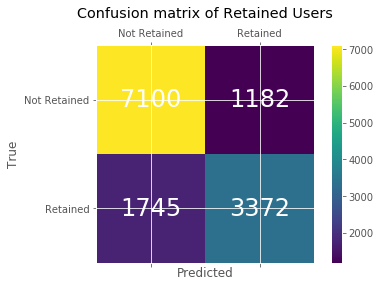

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      8282
           1       0.74      0.66      0.70      5117

    accuracy                           0.78     13399
   macro avg       0.77      0.76      0.76     13399
weighted avg       0.78      0.78      0.78     13399



In [75]:
C_Matrix(best_rf, X_train, X_test, y_train, y_test, best_pred)

In [76]:
# Creating a dataframe of feature importances
feature_import = pd.DataFrame(best_rf.feature_importances_).transpose()
feature_import.columns = list(X.columns)
feature_import = feature_import.transpose()
feature_import.columns = ['RFC Feature Importance']
feature_import.sort_values(by='RFC Feature Importance', ascending=False)

,RFC Feature Importance
avg_rating_by_driver,0.186558
surge_pct,0.133396
weekday_pct,0.120244
city_King's Landing,0.118320
avg_surge,0.092748
avg_dist,0.059053
trips_in_first_30_days,0.058166
ultimate_black_user,0.055257
phone_iPhone,0.045384
phone_Android,0.044795


Our goal was to correctly identify retained riders and we acheived this by using Random Forest which can tolerate noise in the data quite well.

After I fit a RandomForestClassifier  model which initially produced 74% accuracy I fine tuned my model following instructions found here https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
Which improved my model to 78% accuracy. Precision, recall, and F1 were similar to accuracy: 78%, 78%, and 79% . The lowest score on an individual class was recall with only a 66% on the positive class ('retained'). Since this is very important as it is the mission of the study (to determine which variables contribute to RETENTION) then this needs to be worked on.

TOP 3 Factors leading to driver retention

 1) avg_rating_by_driver, 2) surge_pct, and 3) weekday_pct top the list in our feature importance data, but they are not unusually higher than the predictors that follow. I think that I need another 6 months of data to make more accurate conclusions on these retention factors.

The dataset has last_trip_date, surge_pct, and weekday_pct to determine use, but these alone are insufficient to capture the full picture why a rider's uses the  service. I believe it likely that collection and analysis of more comprehensive use data would be effective at improving the model. Can data be tied to certain University or Business Districts?  Can major events be tracked as well to attribute to surges?  Are there driving and parking restrictions in the city. Can weather data contribute to issues as well.  

As for the data we have, we can look at the top three important features to see if there are some actionable insights.